## -1. To Do List
Read npy file, which contain performance information and use those to train instead.

# 0. Imports and setup 🚧

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm.notebook import tqdm
from datetime import datetime
import scipy.stats

## 0.1 Test torch 🔋

In [2]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.5361, 0.9963, 0.9699],
        [0.4574, 0.7398, 0.9836],
        [0.8733, 0.9907, 0.6093],
        [0.9669, 0.9720, 0.8463],
        [0.5281, 0.5129, 0.6118]])


## 1. Load data 🔋

In [3]:
# mnist_training_set = torchvision.datasets.MNIST(
#     "data", train=True, download=True, transform=torchvision.transforms.ToTensor()
# )
# mnist_validation_set = torchvision.datasets.MNIST(
#     "data", train=False, download=True, transform=torchvision.transforms.ToTensor()
# )
# print(mnist_training_set)

In [4]:
# batch_size = 64

# training_dataloader = torch.utils.data.DataLoader(
#     mnist_training_set, shuffle=True, batch_size=batch_size
# )
# # validation_dataloader = torch.utils.data.DataLoader(
# #     mnist_validation_set, shuffle=True, batch_size=batch_size
# # )
# print(training_dataloader)

Image shape
(256, 64)
1.0
(359, 16385)
Please recheck the input size


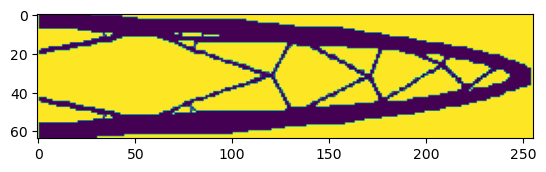

In [86]:
from PIL import Image
import glob
from numpy import genfromtxt

#load training images
design_vectors = []
blfs = []
path = 'E:\dev\Fall23Project\dataset/*.png'
path_dummy = 'E:\dev\Fall23Project\dataset_dummy/*.png'
path_buckling = "E:\dev\Fall23Project\dataset\Images/*.png"

#load the dataset
blf_vector = genfromtxt("E:\dev\Fall23Project\dataset\logT.csv", delimiter=',')

new_size = (256,64)
for filename in glob.glob(path_buckling):
    idx = filename.split("\\")[-1].strip(".png")
    # print(idx)

    blf_val = blf_vector[int(idx)-1]

    im=Image.open(filename).convert('L')
    im = im.resize(new_size, resample=0) 
    
    im_array = np.expand_dims(np.array(im).astype(np.float32)/255, axis = 0)
    im_array_flatten = im_array.reshape(256*64)  # flatten x  shape[0] is the batch size, -1 is the last dimension of x
    # print(im_array.shape)
    
    # blfs.append(blf_val)
    #append blf value to the end of the vector.

    design_vector = np.append(im_array_flatten,blf_val)
    design_vectors.append(design_vector)#




print("Image shape")
print(design_vectors[0][:-1].reshape(new_size).shape)
print(max(design_vectors[0][:-1]))

design_vectors = np.array(design_vectors)
print(design_vectors.shape)
imgplot = plt.imshow(design_vectors[0,:-1].reshape(64,256))

if design_vectors.shape[0] != len(blfs):
    print("Please recheck the input size")


In [87]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64

print("\nTotal datapoints")
print(len(design_vectors))


training_images = design_vectors[:int(len(design_vectors)*0.7)]
validation_images = design_vectors[int(len(design_vectors)*0.7)+1:]
print("\nTraining Images")
print(training_images.shape)

print("\nValidation Images")
print(validation_images.shape)
training_images = torch.Tensor(training_images)
training_images = np.array(training_images)
training_dataloader = DataLoader(training_images, shuffle= True, batch_size = batch_size) # create your dataloader


validation_images = torch.Tensor(validation_images)
validation_images = np.array(validation_images)
validation_dataloader = DataLoader(validation_images, shuffle= True, batch_size = batch_size) # create your dataloader



Total datapoints
359

Training Images
(251, 16385)

Validation Images
(107, 16385)


## 2. Autoencoder


In [88]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        # can use other losses too, MAE, etc.
        self.loss = torch.nn.MSELoss() #Binary Cross Entropy
        
    def forward(self, x):
        encoded = self.encoder(x) #x is the image of the digit
        decoded = self.decoder(encoded)
        return decoded

    def reconstruction_loss(self, input_image, target_image):
        return self.loss(input_image, target_image) 

An autoencoder is as simple as that! That said, we do need to define the encoders and decoders. We'll keep things simple and simply declare them using `Sequential` wrappers.

In [206]:
class Encoder(torch.nn.Module):
  #we are dealing with images -> use convolutional network.
    def __init__(self, latent_dimensionality=2):
        super(Encoder, self).__init__()

        input_size_flatten = 256*64
        self.fc_1 = torch.nn.Linear(in_features= input_size_flatten, out_features=1000)
        self.fc_2 = torch.nn.Linear(in_features= 1000, out_features=100)
        #add blf to it, so the size become 100 + 1 
        self.fc_3 = torch.nn.Linear(in_features= 100 , out_features=latent_dimensionality)
    
    def forward(self, x):
        # print("Before: ", x.size())

        blf = x[...,-1]
        x = x[...,:-1]
        # print("After: ", x.size())
        #Have to check dimensions
        # x = self.conv_1(x)  # 1x64x64 -> 16x62x62
        # x = F.relu(x) # to learn non-linear behavior
        # x = self.conv_2(x)  # 16x62x62 -> 32x60x60
        # x = F.relu(x)
        # x = self.pool_1(x)  # 32x60x60 -> 32x30x30
        # x = self.conv_3(x)  # 32x30x30 -> 64x28x28
        # x = F.relu(x)
        # x = self.pool_2(x)  # 64x28x28 -> 64x14x14
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        # print(x)
        # print(blf)
        # x = torch.cat([x,blf], dim=0)
        x = self.fc_3(x)
        return x


# the decoder essentially mirrors the architecture of the encoder
class Decoder(torch.nn.Module):
    def __init__(self, latent_dimensionality=2):
        super(Decoder, self).__init__()

        self.fc_1 = torch.nn.Linear(in_features=latent_dimensionality, out_features=100)
        self.fc_2 = torch.nn.Linear(in_features=100, out_features = 1000)
        self.fc_3 = torch.nn.Linear(in_features=1000, out_features = 256*64)

        # self.avgpool2d = torch.nn.AvgPool2d((256,64), stride=(2,2), padding = (2,2))
        # self.upsample_1 = torch.nn.UpsamplingNearest2d(scale_factor=(2, 2))

        # self.upsample_1 = torch.nn.UpsamplingNearest2d(scale_factor=(2, 2))
        # self.conv_1 = torch.nn.Conv2d(
        #     in_channels=64,
        #     out_channels=32,
        #     kernel_size=(3, 3),
        #     stride=(1, 1),
        #     padding=(2, 2),
        # )
        # self.upsample_2 = torch.nn.UpsamplingNearest2d(scale_factor=(2, 2))
        # self.conv_2 = torch.nn.Conv2d(
        #     in_channels=32,
        #     out_channels=16,
        #     kernel_size=(3, 3),
        #     stride=(1, 1),
        #     padding=(2, 2),
        # )
        # self.conv_3 = torch.nn.Conv2d(
        #     in_channels=16,
        #     out_channels=1,
        #     kernel_size=(3, 3),
        #     stride=(1, 1),
        #     padding=(2, 2),
        # )

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        # x = x.view(-1, 1, 64*256 )
        # x = self.avgpool2d(x)
        # x = self.upsample_1(x)
        x = torch.sigmoid(x)  # squeeze pixel value between 0 and 1

        # x = self.upsample_1(x)
        # x = self.conv_1(x)
        # x = F.relu(x)
        # x = self.upsample_2(x)
        # x = self.conv_2(x)
        # x = F.relu(x)
        # x = self.conv_3(x)
       

        return x

In [207]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [208]:
ae_model = AutoEncoder(encoder=Encoder(), decoder=Decoder()).to(device)

In [209]:
# summary(ae_model, input_size=(1, 28, 28))
summary(ae_model, input_size=(1,256*64+1))
# summary(ae_model, input_size=(1, 64, 256))

Before:  torch.Size([2, 1, 16385])
After:  torch.Size([2, 1, 16384])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]      16,385,000
            Linear-2               [-1, 1, 100]         100,100
            Linear-3                 [-1, 1, 2]             202
           Encoder-4                 [-1, 1, 2]               0
            Linear-5               [-1, 1, 100]             300
            Linear-6              [-1, 1, 1000]         101,000
            Linear-7             [-1, 1, 16384]      16,400,384
           Decoder-8             [-1, 1, 16384]               0
Total params: 32,986,986
Trainable params: 32,986,986
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.27
Params size (MB): 125.84
Estimated Total Size (MB): 126.16
----------------------------

In [210]:
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

Before:  torch.Size([64, 1, 16385])
After:  torch.Size([64, 1, 16384])
torch.Size([64, 1, 16384])


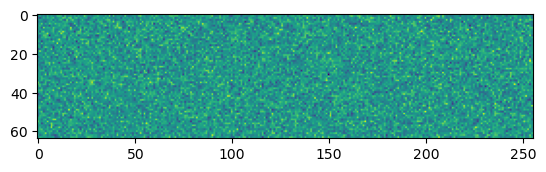

In [211]:
input_tensor = torch.rand(64, 1, 256*64 + 1).to(device)

# Call the autoencoder
output = ae_model(input_tensor)
print(output.size())

imgplot = plt.imshow(output[0].reshape(64,256).detach().cpu().numpy())

In [212]:
# mnist_training_set = torchvision.datasets.MNIST(
#     "data", train=True, download=True, transform=torchvision.transforms.ToTensor())
# batch_size = 64

# training_dataloader = torch.utils.data.DataLoader(
#     mnist_training_set, shuffle=True, batch_size=batch_size
# )

# for j, (digit_images,_) in enumerate(training_dataloader):
#     optimizer.zero_grad() #reset the optimizer in every batch
#     # print(type(digit_images))
#     print(j)
#     print(np.array(digit_images).shape)
#     print(digit_images)
#     break


In [215]:
n_epochs = 200
reporting_frequency = 200
for i in tqdm(range(1, n_epochs + 1)):

    # training
    training_losses = []
    for j, (digit_images) in enumerate(training_dataloader):
        optimizer.zero_grad() #reset the optimizer in every batch
        # print(np.array(digit_images).shape)
        # print(digit_images)

        # digit_images = torch.tensor(digit_images)
        # print(digit_images.shape)
        digit_images = digit_images.to(device)
        # print(digit_images.shape)   
        reconstructed = ae_model(digit_images)
        loss = ae_model.reconstruction_loss(reconstructed, digit_images[...,:-1]) #loss between digit and reconstrcted.

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())
        if (j + 1) % reporting_frequency == 0:
            print(
                "Epoch {0} | Mean training loss after {1} batches: {2:.3f}".format(
                    i, j, np.mean(training_losses)
                )
            )

    #validation
    validation_losses = []
    for j, (digit_images) in enumerate(validation_dataloader):
        digit_images = digit_images.to(device)
        reconstructed = ae_model(digit_images)
        loss = ae_model.reconstruction_loss(reconstructed, digit_images[...,:-1])

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training loss: {1:.3f} | Mean validation loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )

  0%|          | 0/200 [00:00<?, ?it/s]

Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([59, 16385])
After:  torch.Size([59, 16384])
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([43, 16385])
After:  torch.Size([43, 16384])
Epoch 1 | Mean training loss: 0.081 | Mean validation loss: 0.083
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([59, 16385])
After:  torch.Size([59, 16384])
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([43, 16385])
After:  torch.Size([43, 16384])
Epoch 2 | Mean training loss: 0.082 | Mean validation loss: 0.083
Before:  torch.Size([64, 16385])
After:  torch.Size([64, 16384])
Before:  torch.Size([64

<function matplotlib.pyplot.show(close=None, block=None)>

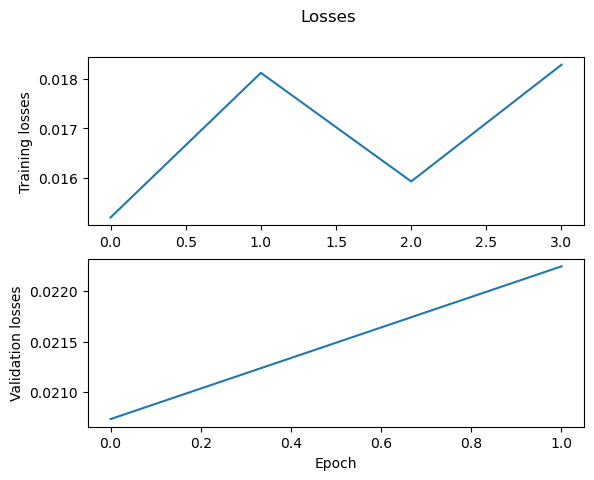

In [216]:
#plot losses
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Losses')

ax1.set_ylabel('Training losses')


p1 = ax1.plot(training_losses)

ax2.set_ylabel('Validation losses')
ax2.set_xlabel("Epoch")

p2 = ax2.plot(validation_losses)

plt.show

In [217]:
ae_model.eval() #put this to inference mode. (good practice to do so)

AutoEncoder(
  (encoder): Encoder(
    (fc_1): Linear(in_features=16384, out_features=1000, bias=True)
    (fc_2): Linear(in_features=1000, out_features=100, bias=True)
    (fc_3): Linear(in_features=100, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=100, bias=True)
    (fc_2): Linear(in_features=100, out_features=1000, bias=True)
    (fc_3): Linear(in_features=1000, out_features=16384, bias=True)
  )
  (loss): MSELoss()
)

torch.Size([64, 16385])


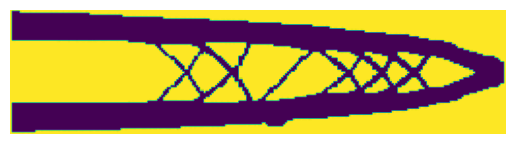

Before:  torch.Size([16385])
After:  torch.Size([16384])


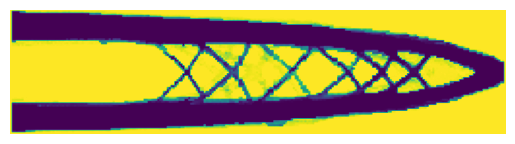

In [252]:
img_sample = next(iter(training_dataloader)).to(device)
print(img_sample.shape)
i = 10
plt.imshow(img_sample[i,:-1].reshape(64,256).cpu())
plt.axis("off")
plt.show()
plt.imshow(ae_model(img_sample[i]).detach().reshape(64,256).cpu())
plt.axis("off")
plt.show()

In [ ]:
def get_all_encodings(model, dataloader):
    all_encoded = []
    all_labels = []
    for j, digit_images in enumerate(dataloader):
        encoding = model.encoder(digit_images.to(device)).detach().cpu().numpy()
        all_encoded.append(encoding)
        #all_labels.append(labels.numpy())

    all_encoded = np.concatenate(all_encoded)
    #all_labels = np.concatenate(all_labels)
    return all_encoded #, all_labels


def plot_mnist_encoding(model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Training data
    ax[0].set_title(label="Encoding of Topology training set")
    all_encoded  = get_all_encodings(model, training_dataloader)
    all_labels = np.zeros(int(all_encoded.shape[0]))
    training_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter = ax[0].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_labels,
        alpha=0.2,
        cmap="plasma",
        label="Training",
    )

    ax[0].legend(*scatter.legend_elements(), loc="lower left", title="Labels")

    # Validation data
    ax[1].set_title(label="Encoding of Topology validation set")
    all_encoded = get_all_encodings(model, validation_dataloader)
    all_labels = np.zeros(int(all_encoded.shape[0]))
    validation_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter = ax[1].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_labels,
        alpha=0.5,
        marker="+",
        cmap="plasma",
    )

    ax[1].legend(*scatter.legend_elements(), title="Labels", bbox_to_anchor=(1, 0.5))

    # adjust such that both subplots have same bounds
    ax[0].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )
    ax[1].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )

    ax[0].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )
    ax[1].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )

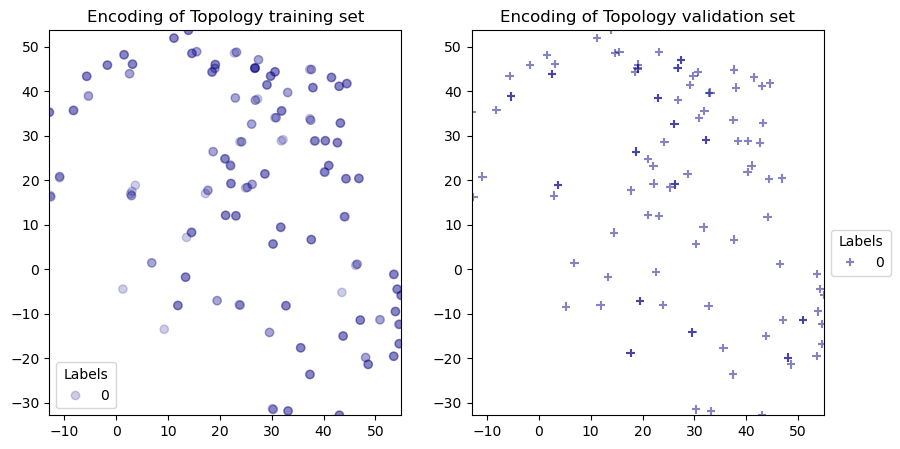

In [ ]:
plot_mnist_encoding(ae_model)

The scatter plots of the encoded data above demonstrates that the encoder does a decent job at separating digites of different classes despite the extremely reduced dimensionality of the latent space. That said, the latent space is not necessarily meaningful. There are plenty of regions that are empty and the encoding does not follow a predictable structure making it difficult to use this latent space to generate samples.

To bring structure to the latent space, we need to enforce some sort of constraint over the structure of the latent space. This is where **Variational Autoencoders** (VAE) come in.

Let's save the model. All we have to do is save the so-called `state_dict` of the trained model, i.e. the model weights/parameters. We can then reload the model by simply loading it onto the model (as long as the model architecture is unchanged). This is the only thing we really need to save as long as we keep track of the architecture of the network we built. More details on saving models can be found in the [PyTorch documentation](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html)

In [ ]:
saved_file_name = "mnist_ae_weights.pth"  # the extension does not matter
# Save learned parameters
torch.save(ae_model.state_dict(), saved_file_name)

In [ ]:
# Load model parameters
reloaded_ae_model = AutoEncoder(encoder=Encoder(), decoder=Decoder()).to(device)
reloaded_ae_model.load_state_dict(torch.load(saved_file_name))
reloaded_ae_model.eval()

AutoEncoder(
  (encoder): Encoder(
    (fc_1): Linear(in_features=16384, out_features=1000, bias=True)
    (fc_2): Linear(in_features=1000, out_features=100, bias=True)
    (fc_3): Linear(in_features=100, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=100, bias=True)
    (fc_2): Linear(in_features=100, out_features=1000, bias=True)
    (fc_3): Linear(in_features=1000, out_features=16384, bias=True)
  )
  (loss): MSELoss()
)

## 3. Variational autoencoder
We have built a vanilla autoencoder. As we've seen, its latent space does not look amazing. Let's see if how the latent space of an equivalent variational autoencoder looks!

In [ ]:
class VariationalAutoEncoder(AutoEncoder):
    def __init__(self, encoder, decoder, latent_dimensionality):
        super(VariationalAutoEncoder, self).__init__(encoder, decoder)

        self.latent_dimensionality = latent_dimensionality

    def forward(self, x):
        x = self.encoder(x)
        mu = x[:, : self.latent_dimensionality]
        log_variance = x[:, self.latent_dimensionality :]
        # sample from gaussian dis
        # project to log sigma^2 so we dont get negative values.
        variance = torch.exp(log_variance) #get rid of the negatives?
        eps = torch.randn_like(variance) #sample from a normal distribution
        sample = mu + torch.sqrt(variance) * eps #randomly scale, close to mu but not mu.

        x = self.decoder(sample)
        return x, mu, log_variance #we need mu and log_variance to compute KLdivergence.

    def kullback_leibler_divergence(self, mu, log_variance):
      #commonly derive expression
        return 0.5 * torch.mean(mu ** 2 + torch.exp(log_variance) - (1 + log_variance))

In [ ]:
vae_model = VariationalAutoEncoder(
    Encoder(latent_dimensionality=4),
    Decoder(latent_dimensionality=2),
    latent_dimensionality=2,
).to(device)

In [ ]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

In [ ]:
n_epochs = 200
reporting_frequency = 200
for i in tqdm(range(1, n_epochs + 1)):

    # training
    training_losses = []
    for j, (digit_images) in enumerate(training_dataloader):
        optimizer.zero_grad()
        digit_images = digit_images.to(device)
        reconstructed, mu, log_variance = vae_model(digit_images)
        reconstruction_loss = vae_model.reconstruction_loss(reconstructed, digit_images)
        kl_divergence_loss = vae_model.kullback_leibler_divergence(mu, log_variance)

        #loss has 2 terms -> reconstruction loss and kl_divergence_loss
        #scale 0.01 so it't not too big/small so it includes the kl_divergence, but not too much that interrupt the workflow.
        loss = reconstruction_loss + 0.01 * kl_divergence_loss

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())
        if (j + 1) % reporting_frequency == 0:
            print(
                "Epoch {0} | Mean training loss after {1} batches: {2:.3f}".format(
                    i, j + 1, np.mean(training_losses)
                )
            )

    # validation
    validation_losses = []
    for j, (digit_images) in enumerate(validation_dataloader):
        digit_images = digit_images.to(device)
        reconstructed, _, _ = vae_model(digit_images)
        loss = vae_model.reconstruction_loss(reconstructed, digit_images)

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training total loss: {1:.3f} | Mean validation reconstruction loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 | Mean training total loss: 0.319 | Mean validation reconstruction loss: 0.098
Epoch 2 | Mean training total loss: 0.131 | Mean validation reconstruction loss: 0.083
Epoch 3 | Mean training total loss: 0.091 | Mean validation reconstruction loss: 0.075
Epoch 4 | Mean training total loss: 0.077 | Mean validation reconstruction loss: 0.072
Epoch 5 | Mean training total loss: 0.072 | Mean validation reconstruction loss: 0.071
Epoch 6 | Mean training total loss: 0.070 | Mean validation reconstruction loss: 0.070
Epoch 7 | Mean training total loss: 0.069 | Mean validation reconstruction loss: 0.071
Epoch 8 | Mean training total loss: 0.069 | Mean validation reconstruction loss: 0.069
Epoch 9 | Mean training total loss: 0.069 | Mean validation reconstruction loss: 0.069
Epoch 10 | Mean training total loss: 0.068 | Mean validation reconstruction loss: 0.069
Epoch 11 | Mean training total loss: 0.068 | Mean validation reconstruction loss: 0.070
Epoch 12 | Mean training total loss: 0.06

<function matplotlib.pyplot.show(close=None, block=None)>

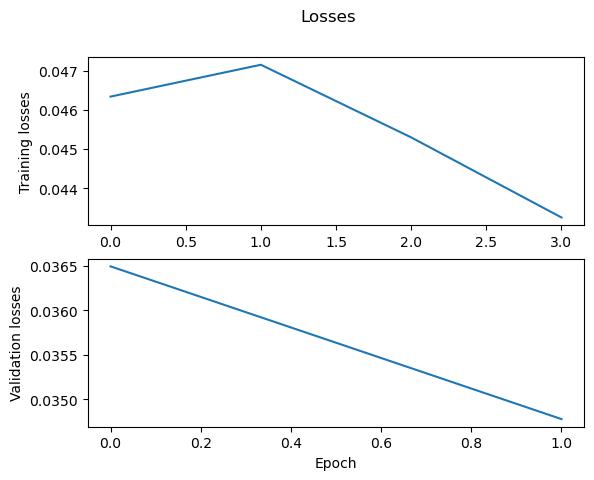

In [ ]:
#plot losses
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Losses')

ax1.set_ylabel('Training losses')


p1 = ax1.plot(training_losses)

ax2.set_ylabel('Validation losses')
ax2.set_xlabel("Epoch")

p2 = ax2.plot(validation_losses)

plt.show

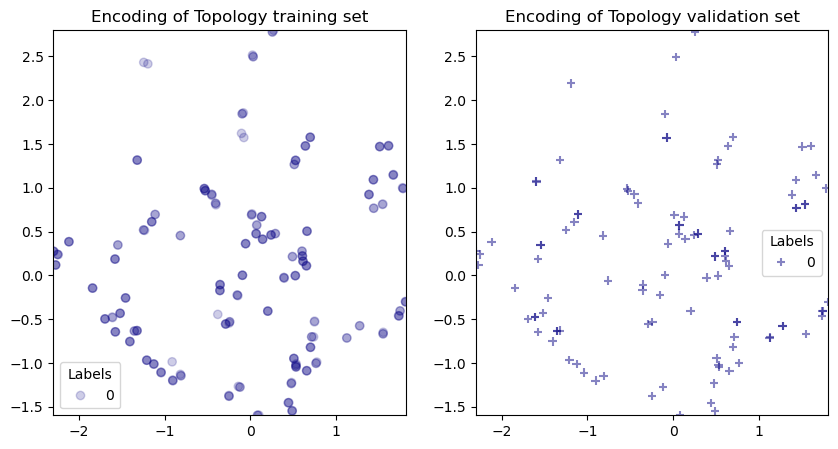

In [ ]:
plot_mnist_encoding(vae_model)

The visualization above, especially in constrast to the identical one done for the regular autoencoder shows the impact of the Kullback-Leibler divergence on the distribution of the encoded points in the latent space.

Let's visualize how the entire latent space decodes at once. How can we do that? Well, we can simply sample the latent space with a grid at a given resolution, decode each point into an image using a decoder and plot the mosaic of decoded images to get a full picture of the latent space.

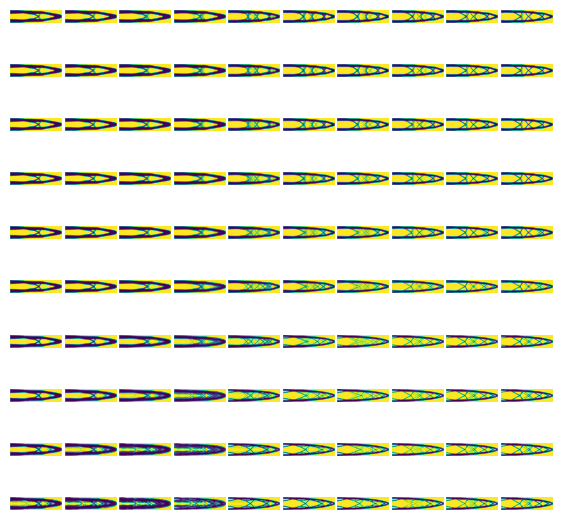

In [ ]:
n = 10  # number of images per rows columns

# grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples

ims = vae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

We sampled the latent space with a simple evenly-space grid. Is that how we should sample the latent space? Not quite. Indeed, with a VAE, we are trying to constrain our encoded data to fit a normal distribution. That is, we are forcing the encoding to be denser around $[0,0]$ and sparser further away from the origin. If we sample with an evenly-spaced grid, we are not sampling those denser regions as much as we should. The visualization above illustrates this as there is little variation in the decoded samples but at the very center of the mosaic. This is where we'd like to have a denser sampling

It turns out there is a simple solution to this issue: sample in probability space. Instead of sampling at $x$ where $[x=-3,x=-2,x=-1,...]$, we'll sample at $x$ where $[p(x)=0.05, p(x)=0.1, p(x)=0.15,...]$ where $p(x)$ is the cumulative density function (cdf) of the normal distribution (i.e. the probability that a sample from the normal distribution would be smaller than $x$). To find these sampling locations, we can use the inverse of the cdf, i.e. the percent point function (ppf) or quantile function, whihc is implemented in `scipy`.

This may seem a little esoteric, so let's plot things to shed some light on what this type of sampling translates to. The plot below shows the distribution of points sampled on an evenly-spaced grid and on a grid that is evenly-spaced in probability terms.

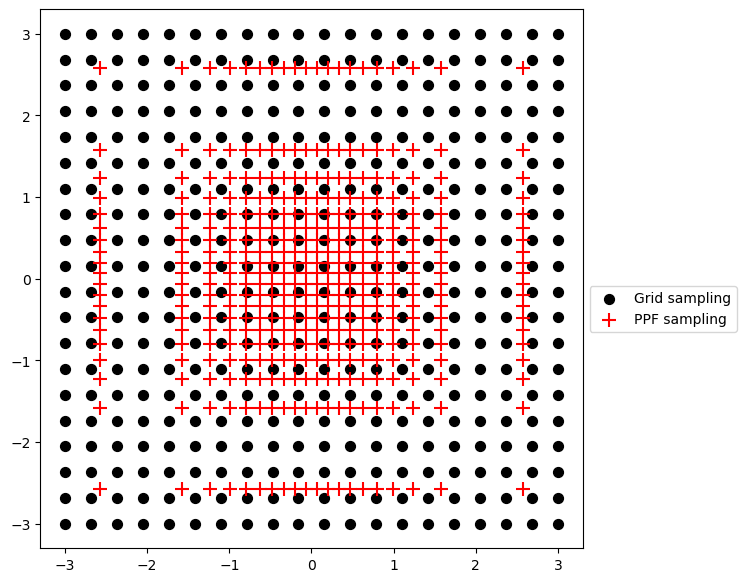

In [ ]:
plt.figure(figsize=(7, 7))

n = 20  # sampling resolution
# evenly-spaced grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], s=50, c="black", label="Grid sampling")

z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], marker="+", s=100, c="red", label="PPF sampling")
plt.legend(fontsize=10, bbox_to_anchor=(1, 0.5))
plt.show()

Now, let's use this sampling scheme on the  VAE (with a higher resolution) and see what we get.

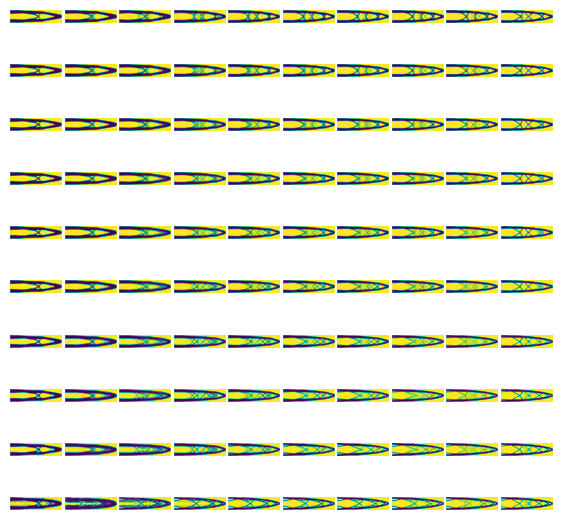

In [ ]:
n = 10  # number of images per rows columns

# grid sampling in latent space
z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

We're now getting much more detail about what's happening closer to the origin, where most of the action truly is. This plot essentially provides a good snapshot of the spectrum of images the decoder is able to generate/reproduce.

What is pretty remarkable is the ability of the decoder to smoothly interpolate between different digits, for example to produce 1s that almost look like 9s or vice-versa.That is the power of latent variable modeling. And now, imagine those were pictures of designs. You could use the same technique to compress a design space and provide a reduced map of designs just like this. We'll discuss this type of approach this week.

Clearly, it cannot reproduce everything, as we would expect. Such heavy compression is almost inevitably lossy, and in this case, a latent dimensionality of 2 is probably too small. We may be able to push things further by increasing the complexity of the model but we would some limit because we just cannot fit an infinite amount of variation in that small space.

Reducing the size of your latent space almost inevitably means reducing its representational power, but a smaller latent space is also easier to explore, visualize, and exploit for design generation, so this trade-off is often worth it.

Let's build the same plot for the autoencoder to demonstrate the difference between the latent spaces produded. Since they encoding is not constrained to meet any sort of distribution, we'll use regular grid sampling across the bounding box of encoded validation samples.

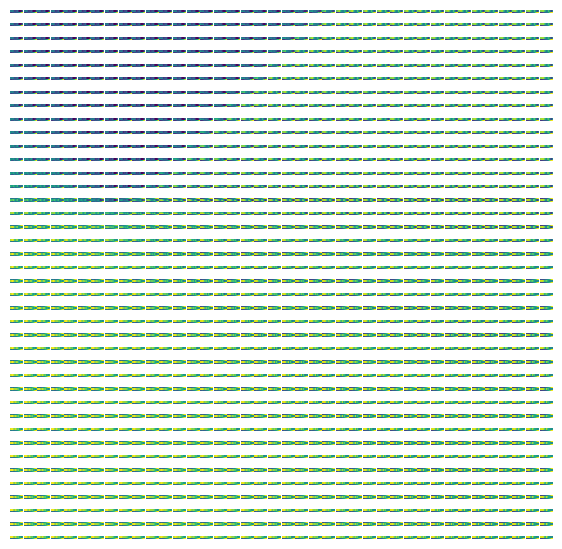

In [ ]:
# get bounding box
ae_encodings = get_all_encodings(ae_model, validation_dataloader)
x_min, y_min = np.min(ae_encodings, axis=0)
x_max, y_max = np.max(ae_encodings, axis=0)


n = 40  # number of images per rows columns

# grid sampling in latent space
z1 = np.linspace(0, 1, n) * (x_max - x_min) + x_min
z2 = np.linspace(0, 1, n) * (y_max - y_min) + y_min
Z1, Z2 = np.meshgrid(z1, z2)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = ae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

Clearly, the latent space is not as "nice" as the one produced by the VAE, i.e. most of the space contains little variations and/or garbage.